In [1]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from joblib import load
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from multimodal import MultimodalClassifierDataset, LOSNetWeighted, collation
from sklearn.metrics import f1_score, balanced_accuracy_score, confusion_matrix, precision_score

/Users/ericmonzon/mambaforge/envs/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
base_path = '../data/split/with-outliers/combined/one-hot-encoded'

static_val = pd.read_csv(f'{base_path}/static_val.csv')
static_test = pd.read_csv(f'{base_path}/static_test.csv')

In [3]:
to_drop = ['los_icu', 'icu_death']

to_scale = [
    'admission_age',
    'weight_admit',
    'charlson_score',
 ]

In [4]:
feature_cols = [col for col in static_val.select_dtypes(include=[np.number]).columns.tolist() if col not in to_drop]

static_val = static_val[feature_cols]
static_test = static_test[feature_cols]

In [5]:
static_scaler = load('../scalers/static_scaler.joblib')

static_val[to_scale] = static_scaler.transform(static_val[to_scale])
static_test[to_scale] = static_scaler.transform(static_test[to_scale])

In [6]:
dynamic = pd.read_csv('../data/dynamic_cleaned.csv')

dynamic_val = dynamic[dynamic['id'].isin(static_val['id'])].copy()
dynamic_test = dynamic[dynamic['id'].isin(static_test['id'])].copy()

In [7]:
def truncate_and_average(df, id_col, max_records=4):
    df_sorted = df.sort_values(by=[id_col, 'charttime'])

    def process_group(group):
        if len(group) > max_records:
            average_data = group.iloc[:-max_records].drop(columns=['charttime']).mean().to_dict()
            average_data[id_col] = group[id_col].iloc[0]
            average_row = pd.DataFrame([average_data])

            return pd.concat([average_row, group.tail(max_records)], ignore_index=True)
        else:
            return group

    return df_sorted.groupby(id_col).apply(process_group).reset_index(drop=True)


In [8]:
dynamic_val = truncate_and_average(dynamic_val, 'id')
dynamic_test = truncate_and_average(dynamic_test, 'id')

/var/folders/px/_hyh_81j2wx_d8kw_xzcl9hr0000gn/T/ipykernel_69487/824680910.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_sorted.groupby(id_col).apply(process_group).reset_index(drop=True)
/var/folders/px/_hyh_81j2wx_d8kw_xzcl9hr0000gn/T/ipykernel_69487/824680910.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df_sorted.groupby(id_col).apply(process_group).reset_index(drop=True)


In [9]:
dynamic_val.groupby('id').size().describe()

count    1940.000000
mean        4.059278
std         0.883691
min         3.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
dtype: float64

In [10]:
dynamic_test.groupby('id').size().describe()

count    776.000000
mean       4.103093
std        0.898567
min        3.000000
25%        3.000000
50%        4.000000
75%        5.000000
max        5.000000
dtype: float64

In [11]:
features = ['aniongap', 'bicarbonate', 'bun', 'calcium', 'chloride', 'creatinine', 'glucose', 'sodium', 'potassium']

dynamic_scaler = load('../scalers/dynamic_scaler.joblib')

dynamic_val[features] = dynamic_scaler.transform(dynamic_val[features])
dynamic_test[features] = dynamic_scaler.transform(dynamic_test[features])

dynamic_val.head()

,id,charttime,aniongap,bicarbonate,bun,calcium,chloride,creatinine,glucose,sodium,potassium
0,20003425,7/21/55 23:27,-1.612645,1.203010,-0.388377,1.142891,-0.713011,-0.631568,-0.426633,-0.605924,0.839394
1,20003425,7/22/55 18:11,-0.616936,-0.241383,-0.499739,0.286751,-0.443310,-0.585160,-0.221369,-0.777459,0.839394
2,20003425,7/23/55 2:19,-1.015220,-0.241383,-0.499739,0.179733,-0.173609,-0.631568,0.116714,-0.777459,0.839394
3,20008098,NaN,0.737227,-0.349712,-0.492315,-0.077109,-1.090592,-0.566597,-0.119944,-1.360676,0.357591
4,20008098,2/9/75 12:40,0.577914,0.119715,-0.722465,0.500786,-1.387264,-0.631568,-0.330038,-1.463597,0.712604


### Dynamic val preprocessing

In [12]:
id_lengths_val = dynamic_val['id'].value_counts().to_dict()
dynamic_val = dynamic_val.sort_values(by=['id', 'charttime'])
dynamic_val = dynamic_val.apply(lambda x: list(x[features]), axis=1).groupby(dynamic_val['id']).agg(list)

dynamic_val

id
20003425    [[-1.6126446935823784, 1.203009557809952, -0.3...
20008098    [[0.5779135333859822, 0.11971546779974476, -0....
20014219    [[1.374480161374477, -0.7830296072087612, -0.8...
20015722    [[-1.0152197225910073, 0.30026448280144596, -0...
20020590    [[-0.6169364085967599, 0.6613625128048484, 0.0...
                                  ...                        
29978469    [[-0.21865309460251256, 0.11971546779974476, -...
29985535    [[-0.41779475159963625, 1.203009557809952, -0....
29989089    [[0.5779135333859822, -0.24138256220365767, -1...
29991038    [[0.17963021939173485, -0.4219315772053589, 1....
29993312    [[1.7727634753687245, -0.4219315772053589, 2.4...
Length: 1940, dtype: object

### Dynamic test preprocessing

In [13]:
id_lengths_test = dynamic_test['id'].value_counts().to_dict()
dynamic_test = dynamic_test.sort_values(by=['id', 'charttime'])
dynamic_test = dynamic_test.apply(lambda x: list(x[features]), axis=1).groupby(dynamic_test['id']).agg(list)

dynamic_test

id
20001305    [[-0.6169364085967599, 0.4808134978031472, 0.4...
20009550    [[0.7770551903831059, 1.3835585728116533, 0.46...
20011505    [[1.1753385043773532, -1.5052256672155662, -0....
20017985    [[-1.0152197225910073, 0.6613625128048484, -0....
20026358    [[-1.0152197225910073, 2.2863036478201595, -0....
                                  ...                        
29957999    [[-1.214361379588131, 0.8419115278065495, -0.7...
29961750    [[-1.214361379588131, 0.11971546779974476, -0....
29967192    [[-0.01951143760538886, -0.6024805922070601, -...
29981257    [[-0.01951143760538886, -1.5052256672155662, -...
29994296    [[0.9761968473802296, -0.6024805922070601, 3.3...
Length: 776, dtype: object

In [14]:
notes = pd.read_csv('../data/notes_cleaned.csv')
notes = notes[['id', 'charttime', 'text', 'interval']]

notes_val = notes[notes['id'].isin(static_val['id'])].copy()
notes_test = notes[notes['id'].isin(static_test['id'])].copy()

In [15]:
validation_data = MultimodalClassifierDataset(
    static=static_val, dynamic=dynamic_val, 
    id_lengths=id_lengths_val, notes=notes_val
    )

test_data = MultimodalClassifierDataset(
    static=static_test, dynamic=dynamic_test, 
    id_lengths=id_lengths_test, notes=notes_test
    )

val_loader = DataLoader(validation_data, batch_size=400, shuffle=False, collate_fn=collation)
test_loader = DataLoader(test_data, batch_size=400, shuffle=False, collate_fn=collation)

In [16]:
seed_value = 24
num_lstm_cells = 1
out_features = 3

torch.manual_seed(seed_value)

cuda_available = torch.cuda.is_available()
if cuda_available:
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

In [17]:
static_input_size = 14
dynamic_input_size = 9
hidden_size = 64

state_dict = torch.load('../saved-models/highest_f1_model.pth', map_location=torch.device('cpu'))

model = LOSNetWeighted(dynamic_input_size=dynamic_input_size, static_input_size=static_input_size,
                       out_features=out_features, hidden_size=hidden_size,
                       task='cls')

model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

model = model.to(device)

model.eval()

print(f'device: {device}')

device: mps


In [18]:
# torch.save(model, '../saved-models/LOSNetWeighted.pth')
# print('saved')

In [19]:
def gen_pred(model, dataloader, device):
    all_true_labels = []
    all_predicted_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='processing batches'):
            packed_dynamic_X, notes_X, notes_intervals, static_batch, los = batch

            packed_dynamic_X = packed_dynamic_X.to(device)
            los = los.to(device)
            static_X_gpu = static_batch.to(device)

            notes_X_gpu = []
            for notes in notes_X:
                notes_gpu = {key: value.to(device) for key, value in notes.items()}
                notes_X_gpu.append(notes_gpu)


            outputs = model(packed_dynamic_X, notes_X_gpu, notes_intervals, static_X_gpu)
            predicted_labels = torch.argmax(outputs, dim=1).float()
            true_labels = torch.argmax(los, dim=1).float()

            all_true_labels.extend(true_labels.cpu().numpy())
            all_predicted_labels.extend(predicted_labels.cpu().numpy())

    return all_true_labels, all_predicted_labels

# VAL

In [20]:
val_true, val_pred = gen_pred(model, val_loader, device=device)

processing batches:   0%|          | 0/5 [00:00<?, ?it/s]

processing batches: 100%|██████████| 5/5 [06:19<00:00, 75.96s/it]


In [21]:
balanced_accuracy_score(val_true, val_pred)

0.4558312793553971

In [22]:
f1_score(val_true, val_pred, average='weighted')

0.4593245475921347

In [23]:
val_cm = confusion_matrix(val_true, val_pred)

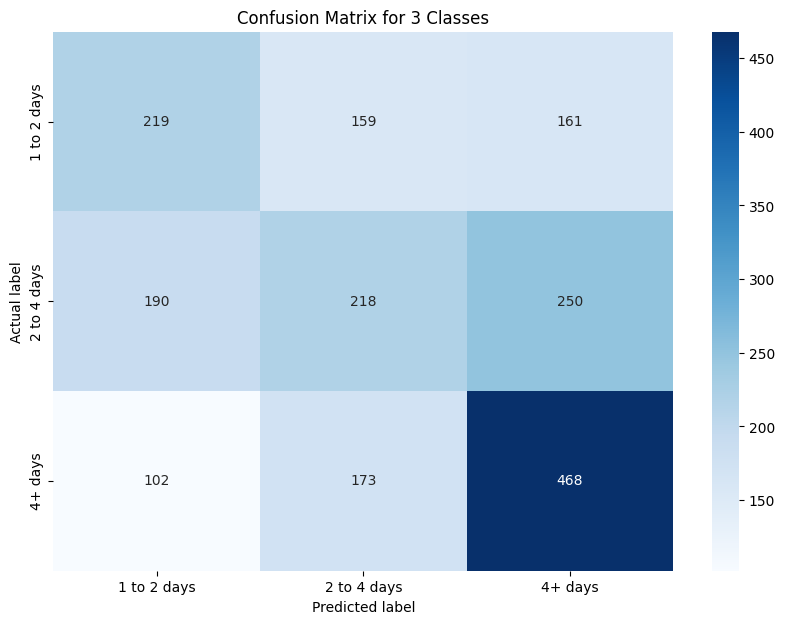

In [24]:
plt.figure(figsize=(10, 7))

sns.heatmap(
    val_cm, annot=True, fmt='d', 
    cmap='Blues', xticklabels=['1 to 2 days', '2 to 4 days', '4+ days'], 
    yticklabels=['1 to 2 days', '2 to 4 days', '4+ days']
    )

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for 3 Classes')
plt.show()

# TEST

In [26]:
test_true, test_pred = gen_pred(model, test_loader, device=device)

processing batches: 100%|██████████| 2/2 [02:41<00:00, 80.56s/it]


In [27]:
f1_score(test_true, test_pred, average='weighted')

0.46006333662626303

In [28]:
balanced_accuracy_score(test_true, test_pred)

0.45633724230048694

In [29]:
test_cm = confusion_matrix(test_true, test_pred)

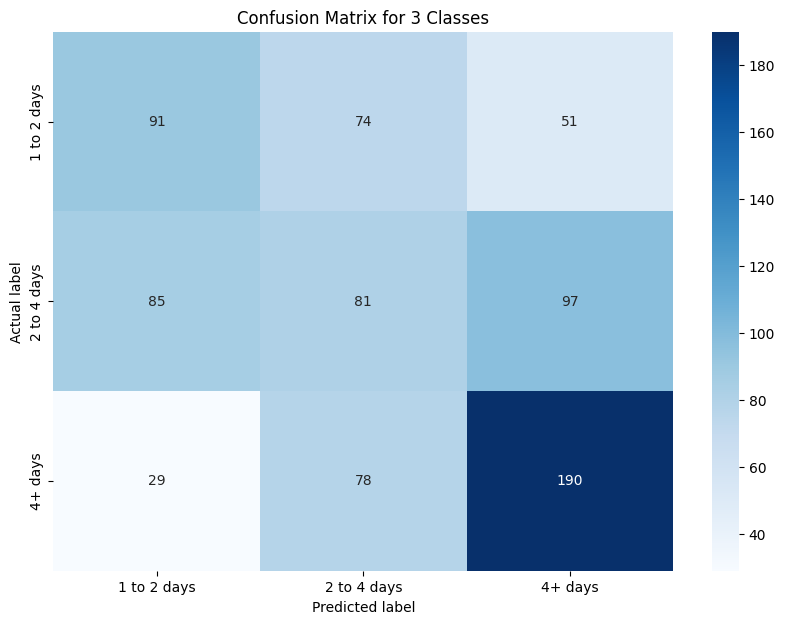

In [30]:
plt.figure(figsize=(10, 7))

sns.heatmap(
    test_cm, annot=True, fmt='d', 
    cmap='Blues', xticklabels=['1 to 2 days', '2 to 4 days', '4+ days'], 
    yticklabels=['1 to 2 days', '2 to 4 days', '4+ days']
    )

plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix for 3 Classes')
plt.show()

In [31]:
model

LOSNetWeighted(
  (time_series_model): LSTM(9, 64, batch_first=True)
  (ht_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (text_model): DataParallel(
    (module): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
       